In [16]:
import sys
sys.path.append('..')
import numpy as np
from envs.KS_environment import KSenv
from envs.KS_solver import KS
import matplotlib.pyplot as plt

# Defining env
N = 64
actuator_locs = ((2 * np.pi) / 4) * np.arange(4)
sensor_locs = ((2 * np.pi) / N) * np.arange(N)
env = KSenv(nu=0.08,
            actuator_locs=actuator_locs,
            sensor_locs=sensor_locs,
            burn_in=0,
            target='e0')

In [2]:
N_t = 1000

observation_init = env.reset()
observation_arr,_  = observation_init
state_arr = env.u
action_arr = np.zeros(env.action_size)
reward_arr = np.zeros((1,))

for i in range(N_t):
    # action = env.action_space.sample() # random sampling
    action = np.zeros(env.action_size) # no actuation
    # action = np.sin(np.ones(env.action_size)*env.dt*i) # sinusoidal activation

    action_arr = np.vstack((action_arr,action)) # save actions

    observation, reward, terminated, truncated, _ = env.step(action)
    observation_arr = np.vstack((observation_arr,observation)) # save observations
    state_arr = np.vstack((state_arr,env.u)) # save state
    reward_arr = np.vstack((reward_arr,reward)) # save state

    if terminated or truncated:
        observation = env.reset()
        print('Terminated')

Text(0, 0.5, 'Reward')

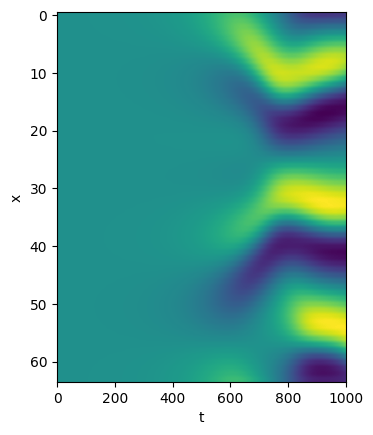

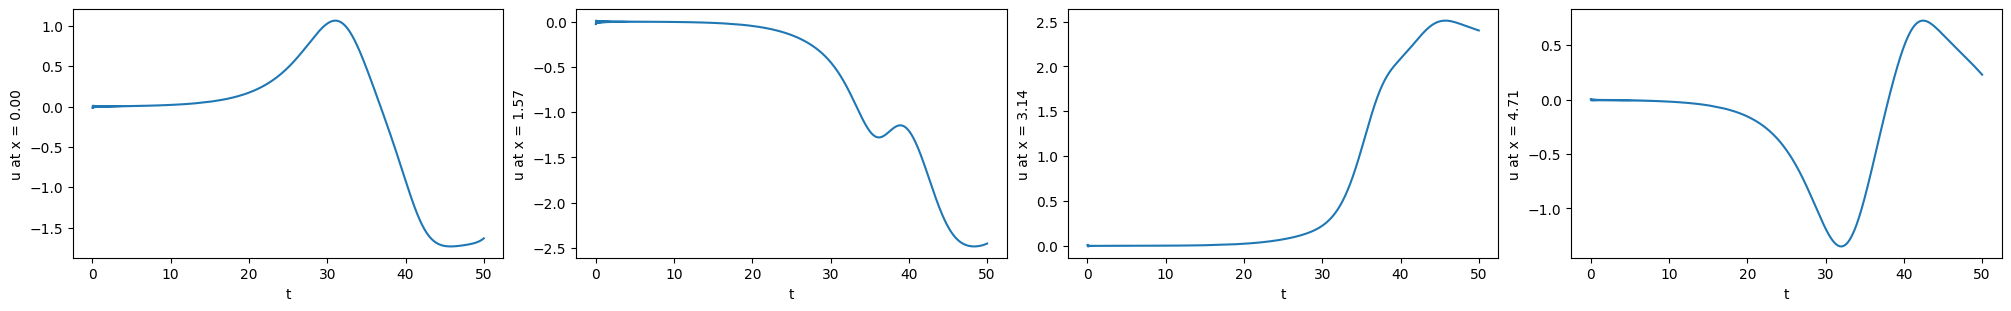

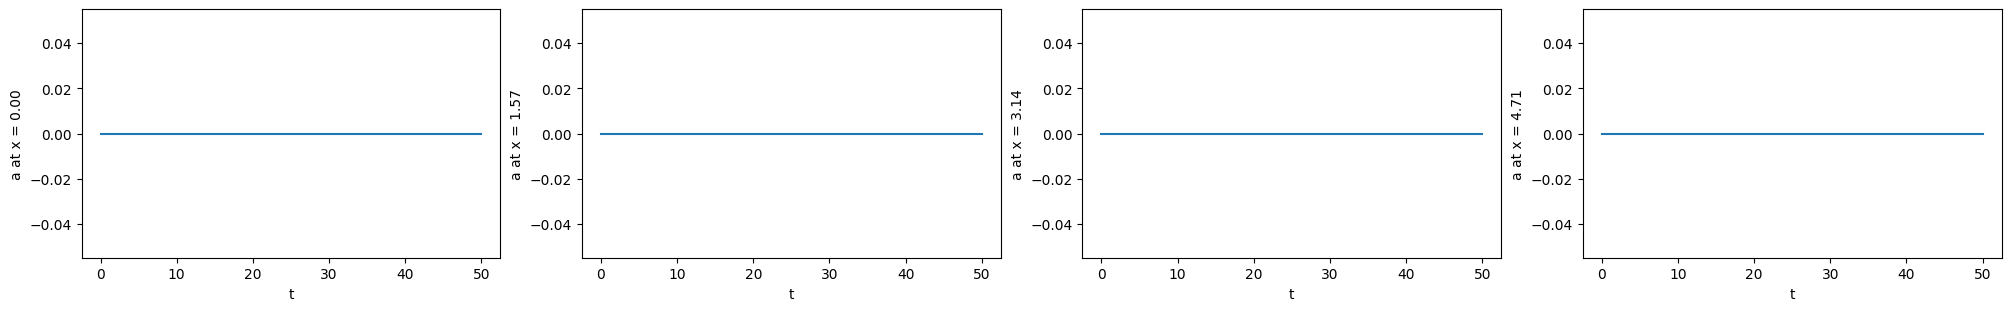

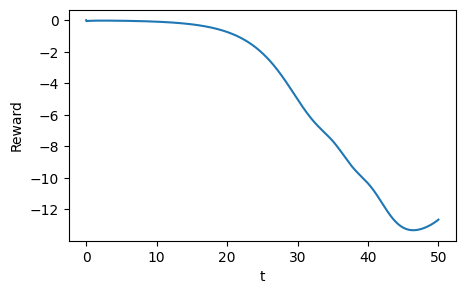

In [19]:
t = env.dt * np.arange(N_t+1)
plt.figure()
plt.imshow(state_arr.T, aspect=20)
plt.xlabel('t')
plt.ylabel('x')

plt.figure(figsize=(20,3),constrained_layout=True)
for sensor_idx, sensor_loc in enumerate(sensor_locs):
    plt.subplot(1,len(sensor_locs),sensor_idx+1)
    plt.plot(t, observation_arr[:,sensor_idx])
    plt.xlabel('t')
    plt.ylabel(f'u at x = {sensor_loc:.2f}')

plt.figure(figsize=(20,3),constrained_layout=True)
for actuator_idx, actuator_loc in enumerate(actuator_locs):
    plt.subplot(1,len(actuator_locs),actuator_idx+1)
    plt.plot(t, action_arr[:,actuator_idx])
    plt.xlabel('t')
    plt.ylabel(f'a at x = {actuator_loc:.2f}')

plt.figure(figsize=(5,3))
plt.plot(t, reward_arr)
plt.xlabel('t')
plt.ylabel('Reward')

# Data assimilation

In [18]:
def advance_f(KS, u, action):
    # just advances the fourier coefficients
    f0 = KS.B @ action
    f = np.fft.rfft(f0, axis=-1)
    u_save = np.copy(u)
    for n in range(3):
        dt = KS.dt / (3 - n)
        # explicit RK3 step for nonlinear term
        u = u_save + dt * KS.nlterm(u, f)
        # implicit trapezoidal adjustment for linear term
        u = (u + 0.5 * KS.lin * dt * u_save) / (1.0 - 0.5 * KS.lin * dt)
    return u

N_high = 64
N_low = 64
dt = 0.05 
nu = 0.08 # the more chaotic system is, we need more modes in the low-order model

actuator_locs = ((2 * np.pi) / 4) * np.arange(4)

my_KS_high = KS(nu=nu,
           N=N_high,
           dt=dt,
           actuator_locs=actuator_locs,
           )
my_KS_low = KS(nu=nu,
           N=N_low,
           dt=dt,
           actuator_locs=actuator_locs,
           )

# Initial data drawn from IID normal distributions
rnd = np.random.RandomState(seed=0)
u0 = rnd.randn(my_KS_high.n)
u0 = 1e-2 * u0

# u0 = np.sin(2*np.pi / my_KS_high.L * my_KS_high.x)

u0 = u0 - u0.mean(axis=-1)
u0_f = np.fft.rfft(u0, axis=-1)
# u0_f = np.fft.fft(u0, axis=-1)
# u0_f = u0_f[:len(my_KS_high.k)]
u0_f_low = my_KS_low.n/my_KS_high.n * u0_f[:len(my_KS_low.k)] # lower order

a0 = np.zeros(len(actuator_locs))
n_t = 2000
u_f = np.zeros((n_t,len(u0_f)), dtype=np.complex128)
u_f[0] = u0_f

u_f_low = np.zeros((n_t,len(u0_f_low)), dtype=np.complex128)
u_f_low[0] = u0_f_low
for i in range(1,n_t):
    a = env.action_space.sample()
    u_f[i] = advance_f(my_KS_high, u_f[i-1], a)
    u_f_low[i] = advance_f(my_KS_low, u_f_low[i-1], a)

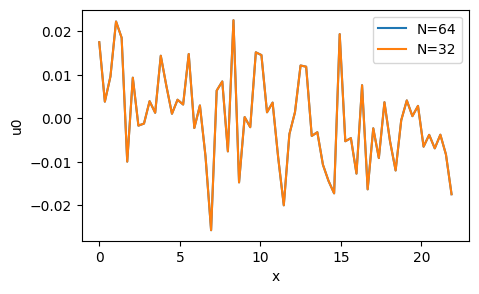

In [19]:
u0_if = np.fft.irfft(u0_f)
u0_if_low = np.fft.irfft(u0_f_low)
plt.figure(figsize=(5,3))
plt.plot(my_KS_high.x, u0_if)
plt.plot(my_KS_low.x, u0_if_low)
plt.xlabel('x')
plt.ylabel('u0')
plt.legend(['N=64','N=32'])

In [20]:
u0_f = np.fft.fft(u0, axis=-1)
k_full = (my_KS_high.n * np.fft.fftfreq(my_KS_high.n)* 2 * np.pi / my_KS_high.L)
x_plot = np.linspace(0,my_KS_high.L,10,endpoint=False)
k_x_full = np.einsum('i,j->ij',x_plot,k_full) * 1j
exp_k_x_full = np.exp(k_x_full)
1/my_KS_high.n * np.real(np.einsum('j,ij->i',u0_f,exp_k_x_full))

array([ 0.01747981,  0.00998345,  0.00012083, -0.01436213, -0.01212341,
       -0.00903858, -0.00023839, -0.00434663,  0.00698304,  0.00029195])

In [21]:
u0_f = np.fft.rfft(u0, axis=-1)
mag = 2/my_KS_high.n * np.abs(u0_f)
phase = np.angle(u0_f)
k_x = np.einsum('i,j->ij',x_plot,my_KS_high.k)
a1 = np.sum(mag * np.cos(k_x + phase), axis = 1)
a2 = 1/my_KS_high.n * np.sum(2*u0_f.real*np.cos(k_x)-2*u0_f.imag*np.sin(k_x), axis=1)

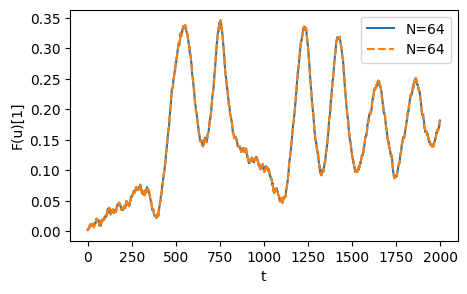

In [22]:
plt.figure(figsize=(5,3))
idx = 1
plt.plot(1/my_KS_high.n * np.abs(u_f[:,idx]))
plt.plot(1/my_KS_low.n * np.abs(u_f_low[:,idx]),'--')
plt.xlabel('t')
plt.ylabel('F(u)[1]')
plt.legend([f'N={my_KS_high.n}',f'N={my_KS_low.n}'])

In [23]:
u = np.fft.irfft(u_f,axis=1)

u_f_low_full = np.hstack((u_f_low,np.conjugate(np.flip(u_f_low[:,1:-1],axis=1))))
k_full = (my_KS_low.n * np.fft.fftfreq(my_KS_low.n)* 2 * np.pi / my_KS_low.L)
x_plot = my_KS_high.x
k_x_full = np.einsum('i,j->ij',x_plot,k_full) * 1j
exp_k_x_full = np.exp(k_x_full)
u_low = 1/my_KS_low.n * np.real(np.einsum('kj,ij->ki',u_f_low_full,exp_k_x_full))

In [24]:
u_init = u[-1].copy()

Text(0, 0.5, 'x')

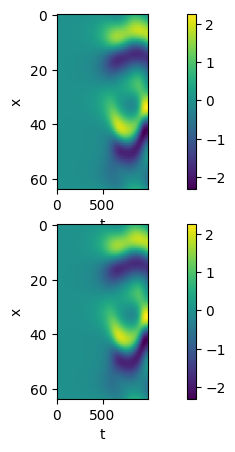

In [42]:
t = dt * np.arange(n_t+1)
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.imshow(u.T, aspect=30)
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')

plt.subplot(2,1,2)
plt.imshow(u_low.T, aspect=30)
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')

In [30]:
from scipy import linalg
rng = np.random.default_rng(5)

def EnKF(Af, d, Cdd, M):
    """ Taken from real-time-bias-aware-DA by Novoa.
        Ensemble Kalman Filter as derived in Evensen (2009) eq. 9.27.
        Inputs:
            Af: forecast ensemble at time t
            d: observation at time t
            Cdd: observation error covariance matrix
            M: matrix mapping from state to observation space
        Returns:
            Aa: analysis ensemble 
    """
    m = np.size(Af, 1)

    psi_f_m = np.mean(Af, 1, keepdims=True)
    Psi_f = Af - psi_f_m

    # Create an ensemble of observations
    if d.ndim == 2 and d.shape[-1] == m:
        D = d
    else: 
        D = rng.multivariate_normal(d, Cdd, m).transpose()
    # Mapped forecast matrix M(Af) and mapped deviations M(Af')
    Y = np.real(np.dot(M, Af)) 
    S = np.real(np.dot(M, Psi_f))
    # because we are multiplying with M first, we get real values
    # so we never actually compute the covariance of the complex-valued state
    # if i have to do that, then make sure to do it properly with the complex conjugate!!
    # Matrix to invert
    C = (m - 1) * Cdd + np.dot(S, S.T)
    Cinv = linalg.inv(C)

    X = np.dot(S.T, np.dot(Cinv, (D - Y)))

    Aa = Af + np.dot(Af, X)
    return Aa

# state dimension
Nq = len(my_KS_low.k) 

# observation points
n_sensors = 3
x_obs = np.linspace(0,my_KS_high.L,n_sensors,endpoint=False)

# observation frequency
dt_obs = 0.05

# get the matrices to do inverse dft
k_high = (my_KS_high.n * np.fft.fftfreq(my_KS_high.n)* 2 * np.pi / my_KS_high.L)
k_x_high = np.einsum('i,j->ij',x_obs,k_high) * 1j
exp_k_x_high = np.exp(k_x_high)

k_low = (my_KS_low.n * np.fft.fftfreq(my_KS_low.n)* 2 * np.pi / my_KS_low.L)
k_x_low = np.einsum('i,j->ij',x_obs,k_low) * 1j
exp_k_x_low = np.exp(k_x_low)

# std of observation error
std_obs = 0.2

# initialize
u0 = rng.normal(scale=1e-1,size=my_KS_high.n)
u0 = u0 - u0.mean(axis=-1)
# u0 = u_init
u0_f = np.fft.rfft(u0, axis=-1)
u0_f_low = my_KS_low.n/my_KS_high.n * u0_f[:len(my_KS_low.k)] # lower order

# initialize ensemble
std_init = 0.5
m = 50
Af_0_real = rng.multivariate_normal(u0_f_low.real, np.diag((u0_f_low.real * std_init) ** 2), m).T
Af_0_complex = rng.multivariate_normal(u0_f_low.imag, np.diag((u0_f_low.imag * std_init) ** 2), m).T
Af_0 = Af_0_real + Af_0_complex * 1j

# no actuation
a0 = np.zeros(len(actuator_locs)) 

# store data
n_t = 100
n_first_obs = 100
n_wait = int(np.round(dt_obs/dt))
n_obs = int(np.ceil((n_t-1)/n_wait))

t = np.zeros((n_t+n_first_obs))
t_obs = np.zeros((n_obs))

u_f = np.zeros((n_t+n_first_obs,len(u0_f)), dtype=np.complex128)
u_f[0] = u0_f

u_f_low_wo_KF = np.zeros((n_t+n_first_obs,len(u0_f_low)), dtype=np.complex128)
u_f_low_wo_KF[0] = u0_f_low

# forecast ensemble
Af = np.zeros((n_t+n_first_obs,len(my_KS_low.k),m), dtype=np.complex128)
Af[0] = Af_0

# analysis ensemble
# Aa = np.zeros((n_obs,len(my_KS_low.k),m), dtype=np.complex128)

y_true_mat = np.zeros((n_obs,n_sensors))
y_obs_mat = np.zeros((n_obs,n_sensors))

# forecast until first observation with zero control input
for i in range(n_first_obs):
    t[i+1] = t[i] + dt
    
    # advance simulation with high order model
    u_f[i+1] = advance_f(my_KS_high, u_f[i], a0)

    # advance simulation with high order model
    u_f_low_wo_KF[i+1] = advance_f(my_KS_low, u_f_low_wo_KF[i], a0)

    # advance forecast with low order model
    for m_idx in range(m):
        Af[i+1,:,m_idx] = advance_f(my_KS_low, Af[i,:,m_idx], a0)
j = 0
for i in range(n_first_obs,n_first_obs+n_t-1):
    # get observation
    if (i-n_first_obs) % n_wait == 0:
        t_obs[j] = t[i]
        u_f_full = np.hstack((u_f[i],np.conjugate(np.flip(u_f[i,1:-1]))))
        y_true = np.real(1/my_KS_high.n * exp_k_x_high @ u_f_full) # noise-free! 
        
        # Define observation covariance matrix
        Cdd = np.diag((std_obs * np.ones(len(y_true)))) * np.max(abs(y_true), axis=0) ** 2
        y_obs = rng.multivariate_normal(y_true, Cdd)
        
        y_true_mat[j] = y_true
        y_obs_mat[j] = y_obs
    
        # # apply enkf
        Af_full = np.vstack((Af[i],np.conjugate(np.flip(Af[i,1:-1,:],axis=0))))
        Aa_full = EnKF(Af_full, y_obs, Cdd, 1/my_KS_low.n * exp_k_x_low)

        Aa = Aa_full[:len(my_KS_low.k),:] 
        # correct Af
        Af[i] = Aa

        # # ZERO-ORDER HOLD
        # sample action
        a = env.action_space.sample()
        j = j + 1

    # # sample action
    # a = env.action_space.sample()
    # next step
    t[i+1] = t[i] + dt
    # advance simulation with high order model
    u_f[i+1] = advance_f(my_KS_high, u_f[i], a)
    u_f_low_wo_KF[i+1] = advance_f(my_KS_low, u_f_low_wo_KF[i], a)

    # advance forecast with low order model
    for m_idx in range(m):
        Af[i+1,:,m_idx] = advance_f(my_KS_low, Af[i,:,m_idx], a)

In [44]:
import jax.numpy as jnp
import jax

Aff = Af[-1].copy()
Aff = np.vstack((Aff,np.conjugate(np.flip(Aff[1:-1,:],axis=0))))

d = y_obs
M = 1/my_KS_low.n * exp_k_x_low
key = jax.random.PRNGKey(0)
m = jnp.size(Aff, 1)

psi_f_m = jnp.mean(Aff, 1, keepdims=True)
Psi_f = Aff - psi_f_m

# Create an ensemble of observations
D = jax.random.multivariate_normal(key, d, Cdd, (m,), method='svd').T
# Mapped forecast matrix M(Af) and mapped deviations M(Af')
Y = jnp.real(jnp.dot(M, Aff))
S = jnp.real(jnp.dot(M, Psi_f))
# because we are multiplying with M first, we get real values
# so we never actually compute the covariance of the complex-valued state
# if i have to do that, then make sure to do it properly with the complex conjugate!!
# Matrix to invert
C = (m - 1) * Cdd + jnp.dot(S, S.T)
# Cinv = jnp.linalg.inv(C)
#jnp.dot(S.T, jnp.dot(Cinv, (D - Y)))
X = jnp.dot(S.T, jnp.linalg.solve(C, D-Y)) 

Aa = Aff + jnp.dot(Aff, X)

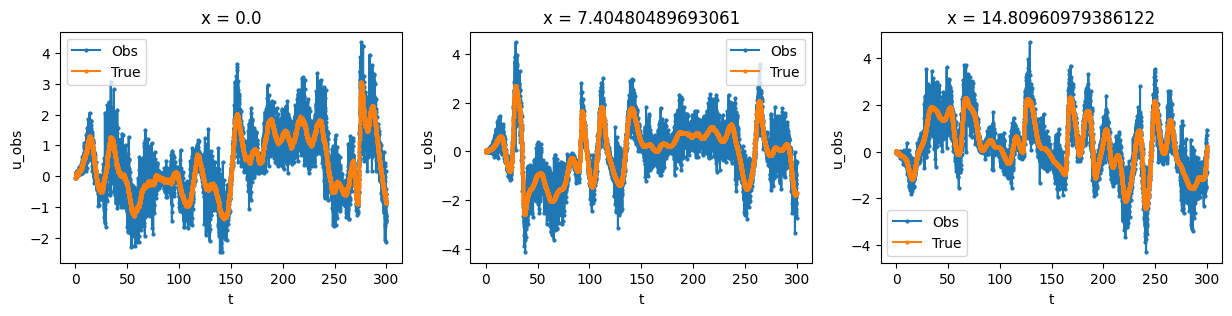

In [86]:
plt.figure(figsize=(15,3))
for i, x in enumerate(x_obs):
    plt.subplot(1,len(x_obs),i+1)
    plt.plot(t_obs,y_obs_mat[:,i], '-o',label='Obs', markersize=2)
    plt.plot(t_obs,y_true_mat[:,i], '-o', label='True', markersize=2)
    plt.xlabel('t')
    plt.ylabel('u_obs')
    plt.title(f'x = {x}')
    plt.legend()
plt.show()

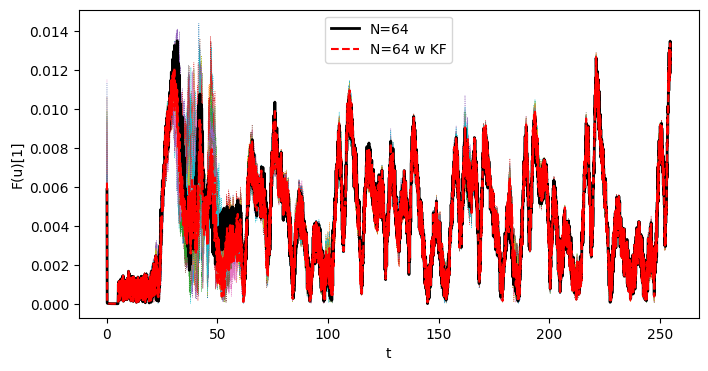

In [190]:
plt.figure(figsize=(8,4))
idx = 9
plt.plot(t,1/my_KS_low.n * np.abs(Af[:,idx,:]),':',linewidth=0.5)
plt.plot(t,1/my_KS_high.n * np.abs(u_f[:,idx]),linewidth=2,color='k',label=f'N={my_KS_high.n}')
plt.plot(t,1/my_KS_low.n * np.abs(np.mean(Af[:,idx,:],axis=-1)),linewidth=1.5,color='red',linestyle='--',label=f'N={my_KS_low.n} w KF')
# plt.plot(t,1/my_KS_low.n * np.abs(u_f_low_wo_KF[:,idx]),'-.',label=f'N={my_KS_low.n} wo KF',color='limegreen')
plt.xlabel('t')
plt.ylabel('F(u)[1]')
plt.legend()
# plt.xlim([0,50])
# plt.ylim([0,0.005])

In [136]:
u = np.fft.irfft(u_f,axis=1)

u_f_low = np.mean(Af, axis=-1)
u_f_low_full = np.hstack((u_f_low,np.conjugate(np.flip(u_f_low[:,1:-1],axis=1))))
k_full = (my_KS_low.n * np.fft.fftfreq(my_KS_low.n)* 2 * np.pi / my_KS_low.L)
x_plot = my_KS_high.x
k_x_full = np.einsum('i,j->ij',x_plot,k_full) * 1j
exp_k_x_full = np.exp(k_x_full)
u_low = 1/my_KS_low.n * np.real(np.einsum('kj,ij->ki',u_f_low_full,exp_k_x_full))

Af_0_full = np.vstack((Af_0,np.conjugate(np.flip(Af_0[1:-1,:],axis=0))))
u0_f_low_full = np.hstack((u0_f_low,np.conjugate(np.flip(u0_f_low[1:-1]))))
u0_low_ens = np.real(1/my_KS_low.n * exp_k_x_full @ Af_0_full)
u0_low_wo_KF = np.real(1/my_KS_low.n * exp_k_x_full @ u0_f_low_full)

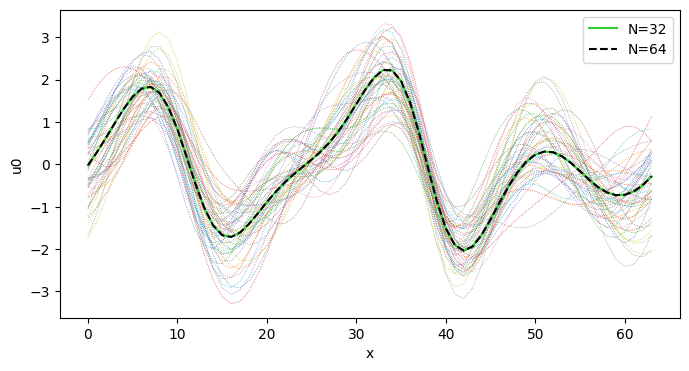

In [137]:
plt.figure(figsize=(8,4))
plt.plot(u0_low_ens,':',linewidth=0.5)
plt.plot(u0_low_wo_KF, color='limegreen', label=f'N={my_KS_low.n}')
plt.plot(u0, color='k', linestyle='--', label=f'N={my_KS_high.n}')
plt.xlabel('x')
plt.ylabel('u0')
plt.legend()
plt.show()

Text(0, 0.5, 'x')

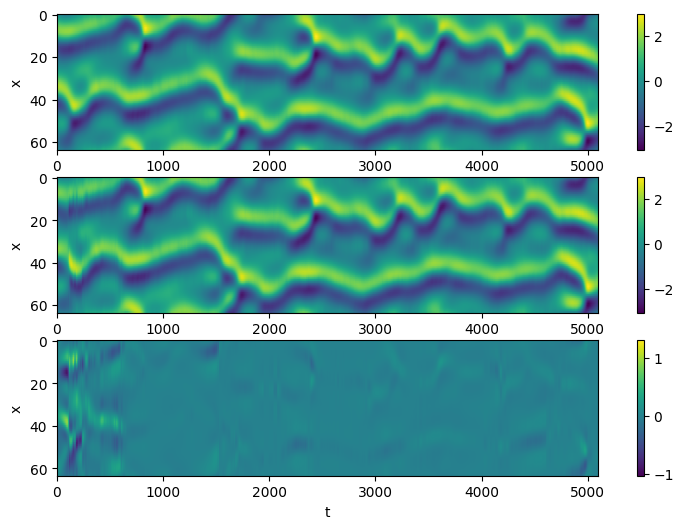

In [138]:
t = dt * np.arange(n_t+1)
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.imshow(u.T, aspect=20)
plt.colorbar()
plt.ylabel('x')

plt.subplot(3,1,2)
plt.imshow(u_low.T, aspect=20)
plt.colorbar()
plt.ylabel('x')

plt.subplot(3,1,3)
plt.imshow(u.T-u_low.T, aspect=20)
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')

In [ ]:
# what are the effects of?
# 1. nu -> more chaotic
# 2. number of modes in the lower/higher order model
# 3. number of sensors
# 4. std of observation
# 5. std of initial condition uncertainty
# 6. sampling rate/analysis update rate 

# it seems like more chaotic, need more modes in the lower order model to be able to track?
# more chaotic means, higher frequency modes have more energy 
# how can we find after what number of modes, the properties are the same? ask Daniel & Elise
# check the fft of higher order model (spatial), check the cut off frequency 
# do we at least need this frequency in our lower order model?
# given some data, how can i determine the minimum number of modes i will need
# does this relate to what andrea did with pod modes

# if we have high level of noise/uncertainty in initial condition and more chaotic system, then need more number of sensors
# above seems irrelevant of lower order model but because of chaos
# less i rely on observation more i must rely on my model vice versa 


# todo:
# 1. check C_dd and initial condition uncertainty. DONE
# size of ensemble > state dimension?
# 2. get some intermediate results to show Luca & others. DONE
# 3. write this code properly in a script so i can run from command line (jax so i can vmap etc)
# 4. run study with varying nu, number of modes, sensors, stds
# 5. add parameter uncertainty

# clean up adjoint-esn repo
# try training esn with adjoint ensemble


In [14]:
import yaml
from pathlib import Path
from gymnasium.wrappers import RecordEpisodeStatistics, TimeLimit
import orbax.checkpoint
from ddpg import DDPG
import sys
sys.path.append('..')
import numpy as np
from envs.KS_environment import KSenv
from envs.KS_solver import KS
import matplotlib.pyplot as plt
from scipy import linalg

def load_config(experiment_path):
    with open(experiment_path / "config.yml", "r") as file:
        config = yaml.unsafe_load(file)
        return config

# load config from experiment
# experiment_path = Path('local_results/KS/run_20240901_214539') 
# experiment_path = Path('local_results/KS/run_20240910_082542') # 32 modes
experiment_path = Path('local_results/KS/run_20240910_091659') # 20 modes

config = load_config(experiment_path)

# create environment
env = KSenv(**config.env)
env = TimeLimit(env, max_episode_steps=config.episode_steps)
env = RecordEpisodeStatistics(env)

# create agent
agent = DDPG(config, env)

# load model weights
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
params_dict = orbax_checkpointer.restore(experiment_path / 'final_model')
params = params_dict["actor"]["target_params"]

# create low order model
# model = KS(
#     nu=config.env.nu,
#     N=config.enKF.low_order_N,
#     dt=env.unwrapped.dt,
#     actuator_locs=config.env.actuator_locs,
#     actuator_scale=config.env.actuator_scale,
# )

# config.enKF.wait_steps = 10

c:\Users\egeoz\Imperial\DA-RL\.venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.action_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_size` for environment variables or `env.get_wrapper_attr('action_size')` that will search the reminding wrappers.
  logger.warn(
c:\Users\egeoz\Imperial\DA-RL\.venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.action_low to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_low` for environment variables or `env.get_wrapper_attr('action_low')` that will search the reminding wrappers.
  logger.warn(
c:\Users\egeoz\Imperial\DA-RL\.venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.action_high to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_high` f

In [15]:
def evaluate_KS_for_plotting1(env, actor, params, eval_episodes=2):
    # this should go in a different file
    x = np.arange(env.unwrapped.N) * 2 * np.pi / env.unwrapped.N

    fig, axs = plt.subplots(
        eval_episodes,
        3,
        width_ratios=[1, 0.55, 1],
        figsize=(10, 3 * eval_episodes),
        constrained_layout=True,
    )

    for i in range(eval_episodes):
        state, _ = env.reset()
        full_state = env.unwrapped.u

        state_arr = np.array(state)
        full_state_arr = np.array(full_state)
        reward_arr = np.zeros((1,))

        terminated = False
        truncated = False
        while not terminated and not truncated:
            # get action from the target actor network
            action = actor.apply(params, state)
            state, reward, terminated, truncated, info = env.step(action)
            full_state = env.unwrapped.u
            state_arr = np.vstack((state_arr, state))
            full_state_arr = np.vstack((full_state_arr, full_state))
            reward_arr = np.vstack((reward_arr, reward))

        # plot the full state and reward
        im = axs[i, 0].imshow(
            full_state_arr.T,
            extent=[0, len(full_state_arr), x[0], x[-1]],
            origin="lower",
            aspect="auto",
        )
        axs[i, 0].set_xlabel("t")
        axs[i, 0].set_ylabel("x")
        cbar = fig.colorbar(im, ax=[axs[i, 0]], location="left")
        cbar.ax.set_title("u")
        axs[i, 0].set_title(
            f"Return={info['episode']['r'][0]:.2f}, Ave. Reward={info['episode']['r'][0]/info['episode']['l'][0]:.2f}"
        )

        axs[i, 1].plot(env.unwrapped.target, x)
        axs[i, 1].plot(full_state_arr[-1, :], x, "--")
        axs[i, 1].set_yticks(axs[i, 0].get_yticks())
        axs[i, 1].set_yticklabels([])
        axs[i, 1].set_ylim(axs[i, 0].get_ylim())
        axs[i, 1].set_title(f"Last Reward={reward:.2f}")
        axs[i, 1].grid()
        axs[i, 1].set_xlabel("u")
        axs[i, 1].legend(["Target", "Last"])

        err = np.abs(env.unwrapped.target[:, None] - full_state_arr.T)
        im = axs[i, 2].imshow(
            err,
            extent=[0, len(full_state_arr), x[0], x[-1]],
            origin="lower",
            aspect="auto",
            cmap="Reds",
        )
        axs[i, 2].set_xlabel("t")
        axs[i, 2].set_yticks(axs[i, 0].get_yticks())
        axs[i, 2].set_yticklabels([])
        axs[i, 2].set_ylim(axs[i, 0].get_ylim())
        cbar = fig.colorbar(im, ax=[axs[i, 2]], location="right")
        axs[i, 2].set_title("|Target - u|")

    return fig

In [17]:
from utils import visualizations as vis
def initialize_ensemble(env, model, u0, std_init, m):
    # fourier transform the initial condition
    u0_f = np.fft.rfft(u0, axis=-1)
    # get lower order
    # make sure the magnitude of fourier modes match
    u0_f_low = model.n / env.unwrapped.N * u0_f[: len(model.k)]
    # create an ensemble by perturbing the real and imaginary parts
    # with the given uncertainty
    Af_0_real = np.random.multivariate_normal(
        u0_f_low.real, np.diag((u0_f_low.real * std_init) ** 2), m
    ).T
    Af_0_complex = np.random.multivariate_normal(
        u0_f_low.imag, np.diag((u0_f_low.imag * std_init) ** 2), m
    ).T
    Af_0 = Af_0_real + Af_0_complex * 1j
    return Af_0


def get_observation_matrix(model, x):
    # get the matrix to do inverse fft on observation points
    k = model.n * np.fft.fftfreq(model.n) * 2 * np.pi / model.L
    k_x = np.einsum("i,j->ij", x, k) * 1j
    exp_k_x = np.exp(k_x)
    M = 1 / model.n * exp_k_x
    return M


def ensemble_to_state(state_ens):
    state = np.mean(state_ens, axis=-1)
    # inverse rfft before passing to the neural network
    state = np.fft.irfft(state)
    return state


def forecast(model, state_ens, action, frame_skip):
    for _ in range(frame_skip):
        # advance forecast with low order model
        for m_idx in range(state_ens.shape[-1]):
            state_ens[:, m_idx] = model.advance_f(state_ens[:, m_idx], action)
    return state_ens


def EnKF(Af, d, Cdd, M):
    """Taken from real-time-bias-aware-DA by Novoa.
    Ensemble Kalman Filter as derived in Evensen (2009) eq. 9.27.
    Inputs:
        Af: forecast ensemble at time t
        d: observation at time t
        Cdd: observation error covariance matrix
        M: matrix mapping from state to observation space
    Returns:
        Aa: analysis ensemble
    """
    m = np.size(Af, 1)

    psi_f_m = np.mean(Af, 1, keepdims=True)
    Psi_f = Af - psi_f_m

    # Create an ensemble of observations
    if d.ndim == 2 and d.shape[-1] == m:
        D = d
    else:
        D = np.random.multivariate_normal(d, Cdd, m).transpose()
    # Mapped forecast matrix M(Af) and mapped deviations M(Af')
    Y = np.real(np.dot(M, Af))
    S = np.real(np.dot(M, Psi_f))
    # because we are multiplying with M first, we get real values
    # so we never actually compute the covariance of the complex-valued state
    # if i have to do that, then make sure to do it properly with the complex conjugate!!
    # Matrix to invert
    C = (m - 1) * Cdd + np.dot(S, S.T)
    Cinv = linalg.inv(C)

    X = np.dot(S.T, np.dot(Cinv, (D - Y)))

    Aa = Af + np.dot(Af, X)
    return Aa


def apply_enKF(model, Af, d, Cdd, M):
    Af_full = np.vstack((Af, np.conjugate(np.flip(Af[1:-1, :], axis=0))))
    Aa_full = EnKF(Af_full, d, Cdd, M)
    Aa = Aa_full[: len(model.k), :]
    return Aa

def evaluate_episode(config, env, actor, params, model, obs_mat):
    # reset the environment
    true_obs, _ = env.reset()
    full_state = env.unwrapped.u

    # initialize enKF
    state_ens = initialize_ensemble(
        env, model, env.unwrapped.u, 5*config.enKF.std_init, config.enKF.m
    )

    # Preallocate arrays
    max_steps = config.episode_steps
    # Calculate the total number of steps
    total_steps = max_steps + config.enKF.observation_starts

    # Preallocate arrays using the types of the existing variables
    true_obs_arr = np.empty((total_steps, *true_obs.shape), dtype=true_obs.dtype)
    obs_arr = np.empty((total_steps, *true_obs.shape), dtype=true_obs.dtype)
    full_state_arr = np.empty((total_steps, *full_state.shape), dtype=full_state.dtype)
    state_ens_arr = np.empty((total_steps, *state_ens.shape), dtype=state_ens.dtype)

    # create an action of zeros to pass
    null_action = np.zeros(env.action_space.shape[0])

    # forecast until first observation
    for i in range(config.enKF.observation_starts):
        # Fill in the preallocated arrays
        true_obs_arr[i] = true_obs
        obs_arr[i] = true_obs
        full_state_arr[i] = full_state
        state_ens_arr[i] = state_ens

        # advance true environment
        true_obs, _, _, _, _ = env.step(action=null_action)
        full_state = env.unwrapped.u

        # advance model
        state_ens = forecast(
            model, state_ens, action=null_action, frame_skip=env.unwrapped.frame_skip
        )

    episode_step = 0
    state = ensemble_to_state(state_ens)

    terminated = False
    truncated = False

    while not terminated and not truncated and episode_step < max_steps:
        index = episode_step + config.enKF.observation_starts
        true_obs_arr[index] = true_obs
        full_state_arr[index] = full_state

        if episode_step % config.enKF.wait_steps == 0:
            # define observation covariance matrix
            obs_cov = (
                np.diag((config.enKF.std_obs * np.ones(len(true_obs))))
                * np.max(abs(true_obs), axis=0) ** 2
            )

            # add noise on the observation
            obs = np.random.multivariate_normal(true_obs, obs_cov)

            # apply enkf to correct the state estimation
            state_ens = apply_enKF(model, state_ens, obs, obs_cov, obs_mat)
            state = ensemble_to_state(state_ens)

            obs_arr[index] = obs
        else:
            obs_arr[index] = true_obs

        # save the analysis state
        state_ens_arr[index] = state_ens

        # get action from the target actor network
        action = actor.apply(params, state)
        # action = env.action_space.sample()
        # action = np.zeros(env.action_size)
        true_obs, reward, terminated, truncated, _ = env.step(action)
        full_state = env.unwrapped.u

        # forecast
        state_ens = forecast(
            model, state_ens, action, frame_skip=env.unwrapped.frame_skip
        )
        episode_step += 1

    # Return only the filled parts of the arrays
    return (
        true_obs,
        full_state,
        state_ens,
        true_obs_arr[: index + 1],
        obs_arr[: index + 1],
        full_state_arr[: index + 1],
        state_ens_arr[: index + 1],
        reward,
    )

def evaluate_KS_for_plotting(env, actor, params, model, config, eval_episodes=1):
    x = env.unwrapped.KS.x
    x_obs = env.unwrapped.observation_locs
    target = env.unwrapped.target

    full_obs_mat = get_observation_matrix(model, x)
    obs_mat = get_observation_matrix(model, x_obs)
    figs = []
    for i in range(eval_episodes):
        (
            true_obs,
            full_state,
            state_ens,
            true_obs_arr,
            obs_arr,
            full_state_arr,
            state_ens_arr,
            _,
        ) = evaluate_episode(config, env, actor, params, model, obs_mat)
        true_obs_arr = np.vstack((true_obs_arr, true_obs))
        obs_arr = np.vstack((obs_arr, true_obs))
        full_state_arr = np.vstack((full_state_arr, full_state))
        state_ens_arr = np.concatenate((state_ens_arr, np.array([state_ens])), axis=0)

        # get full state from low order model
        state_ens_arr_ = np.hstack(
            (state_ens_arr, np.conjugate(np.flip(state_ens_arr[:, 1:-1], axis=1)))
        )
        full_state_ens_arr = np.real(
            np.einsum("kjm,ij->kim", state_ens_arr_, full_obs_mat)
        )
        # get the mean
        full_state_mean_arr = np.mean(full_state_ens_arr, axis=-1)

        # get fourier coefficients
        full_state_arr_f = np.fft.rfft(full_state_arr, axis=1)
        mag_state_arr = 2 / env.unwrapped.N * np.abs(full_state_arr_f)
        mag_state_ens_arr = 2 / model.n * np.abs(state_ens_arr)
        mag_state_mean_arr = np.mean(mag_state_ens_arr, axis=-1)

        # get observations from low order model
        obs_ens_arr = np.real(np.einsum("kjm,ij->kim", state_ens_arr_, obs_mat))
        # get the mean
        obs_mean_arr = np.mean(obs_ens_arr, axis=-1)

        fig = vis.plot_episode(
            x,
            x_obs,
            target,
            full_state_arr,
            full_state_ens_arr,
            full_state_mean_arr,
            mag_state_arr,
            mag_state_ens_arr,
            mag_state_mean_arr,
            true_obs_arr,
            obs_arr,
            obs_ens_arr,
            obs_mean_arr,
        )
        figs.append(fig)
    return figs

In [16]:
eval_env_config = {}
for key, val in config.env.items():
    eval_env_config[key] = val

eval_env_config["N"] = 64

In [17]:
# create environment
eval_env = KSenv(**eval_env_config)
eval_env = TimeLimit(eval_env, max_episode_steps=config.episode_steps)
eval_env = RecordEpisodeStatistics(eval_env)

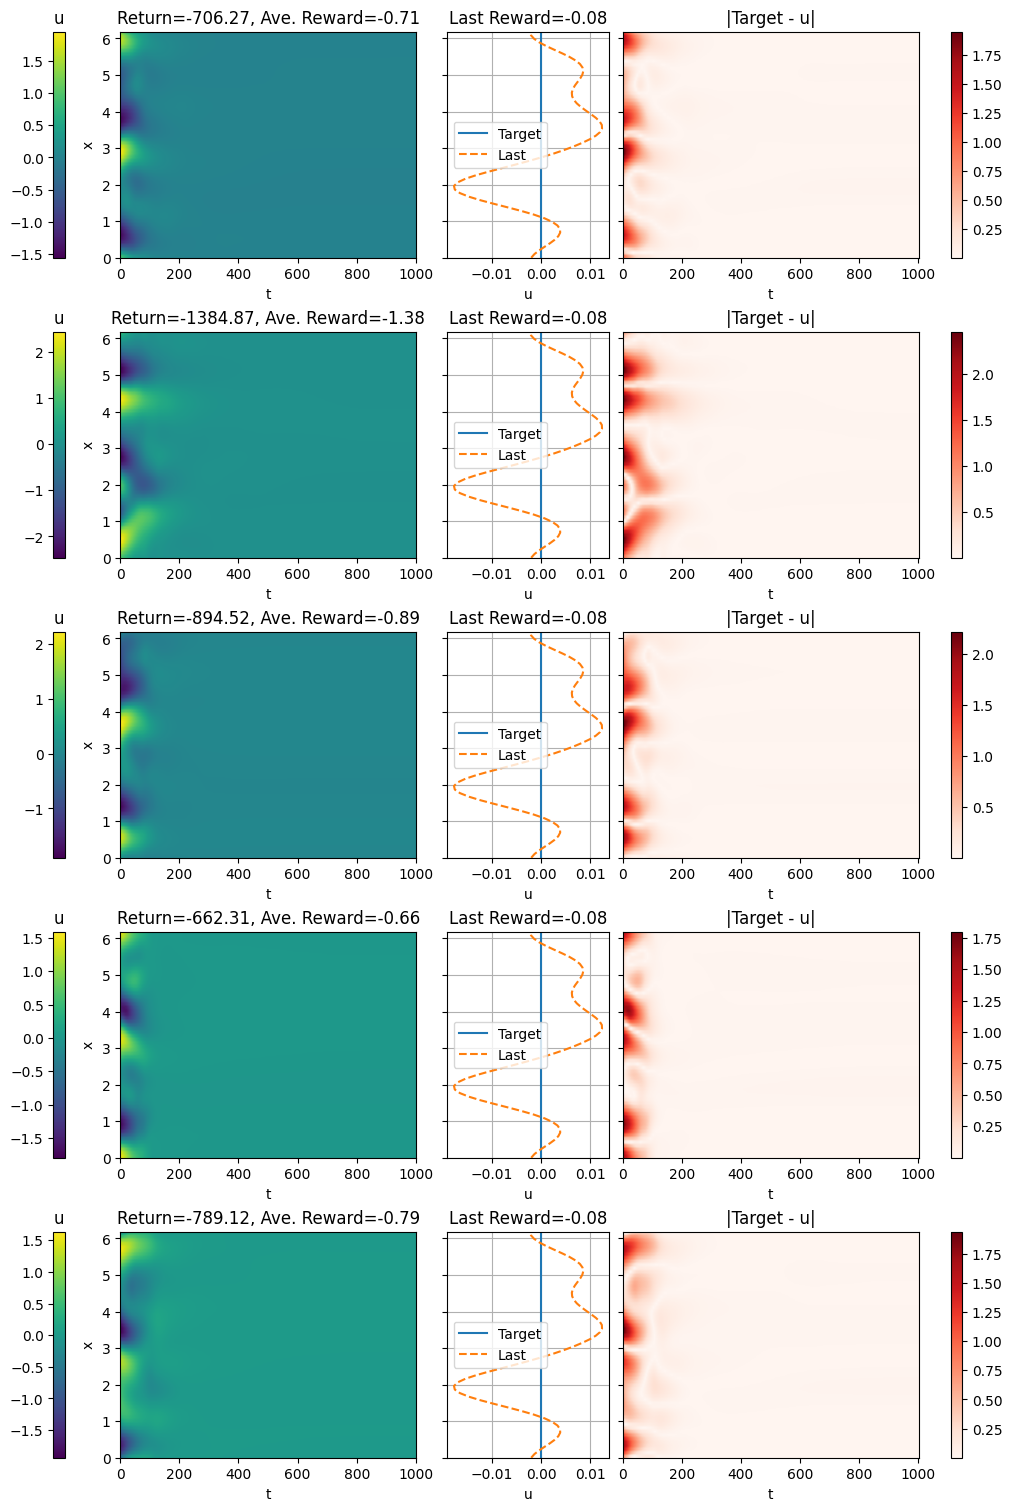

In [18]:
fig = evaluate_KS_for_plotting1(eval_env, agent.actor, params, eval_episodes=5)
plt.show()

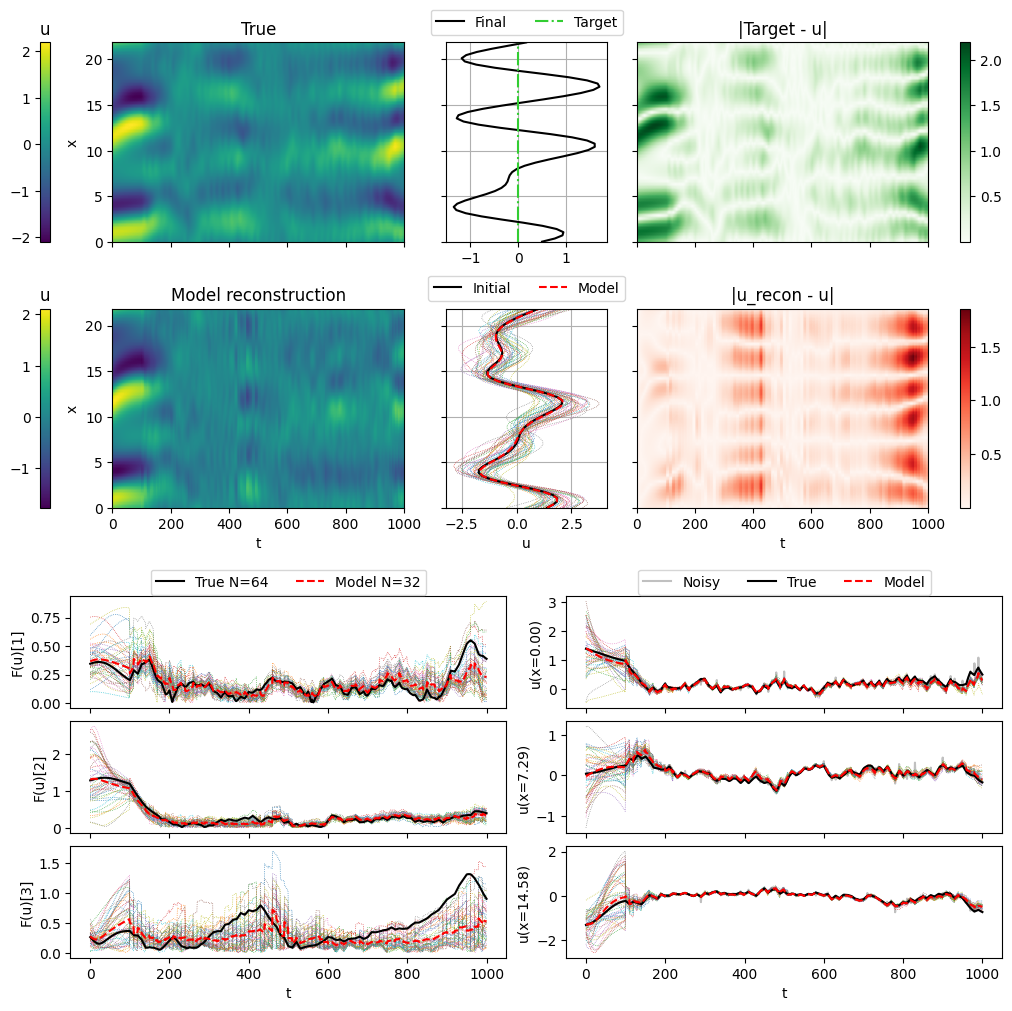

In [22]:
fig = evaluate_KS_for_plotting(env, agent.actor, params, model, config, eval_episodes=1)
plt.show()

## jax

In [48]:
from envs.KS_environment_jax import KSenv as KSenv_jax
from envs.KS_solver_jax import KS as KS_jax
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

# Defining env
N = 64
actuator_locs = ((2 * jnp.pi) / 4) * jnp.arange(4)
sensor_locs = ((2 * jnp.pi) / N) * jnp.arange(N)
env_jax = KSenv_jax(nu=0.08,
            actuator_locs=actuator_locs,
            sensor_locs=sensor_locs,
            burn_in=0,
            target='e0')

In [49]:
from functools import partial
reset_fun = partial(KSenv_jax.reset,N=env_jax.N,B=env_jax.ks_solver.B, 
                              lin=env_jax.ks_solver.lin, 
                              ik=env_jax.ks_solver.ik, 
                              dt=env_jax.ks_solver.dt, 
                              initial_amplitude=env_jax.initial_amplitude, 
                              action_size=env_jax.action_size, 
                              burn_in=env_jax.burn_in, 
                              observation_inds=env_jax.observation_inds)
reset_fun = jax.jit(reset_fun)
step_fun = partial(KSenv_jax.step,frame_skip=env_jax.frame_skip,B=env_jax.ks_solver.B, 
                                               lin=env_jax.ks_solver.lin, 
                                               ik=env_jax.ks_solver.ik, 
                                               dt=env_jax.ks_solver.dt, 
                                               target=env_jax.target,  
                                               actuator_loss_weight=env_jax.actuator_loss_weight, 
                                               termination_threshold=env_jax.termination_threshold, 
                                               observation_inds=env_jax.observation_inds)
step_fun = jax.jit(step_fun)
sample_action_fun = partial(KSenv_jax.sample_continuous_space, low=env_jax.action_low, high=env_jax.action_high, shape=(env_jax.action_size,))

In [50]:
N_t = 1000

obs, _ = env.reset()
state0 = env.u
state_arr1 = state0

state2 = jnp.array(state0)
state_arr2 = state2

for i in range(N_t):
    action = env.action_space.sample() # random sampling
    # action = np.zeros(env.action_size) # no actuation

    obs1, reward1, terminated1, truncated1, _ = env.step(action)
    state1 = env.u
    state_arr1 = np.vstack((state_arr1,state1)) # save state

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
state2, obs2, _ = reset_fun(key=key)

def body_fun(carry, _):
    state, key = carry
    action = sample_action_fun(key)
    key, subkey = jax.random.split(key)
    state, obs, reward, terminated, truncated, _ = step_fun(state, action)
    return (state, subkey), state

_, state_arr2 = jax.lax.scan(body_fun,(state2, subkey), np.arange(N_t))

In [55]:
Af_0.shape

(33, 50)

In [77]:
# Define a function that applies advance_f over multiple steps
B = env_jax.ks_solver.B
lin = env_jax.ks_solver.lin
ik = env_jax.ks_solver.ik
dt = env_jax.ks_solver.dt
state_ens = Af_0
frame_skip = 5
def step_fn(state, _):
        return jax.vmap(KS_jax.advance_f, in_axes=(-1, None, None, None, None, None), out_axes=-1)(
            state, action, B, lin, ik, dt
        ), None

# Use lax.scan to iterate over frame_skip and advance the state
state_ens, _ = jax.lax.scan(step_fn, state_ens, jnp.arange(frame_skip))

In [78]:
state_ens1 = Af_0
for _ in range(frame_skip):
    # advance forecast with low order model
    for m_idx in range(state_ens.shape[-1]):
        state_ens1[:, m_idx] = advance_f(env.KS, state_ens1[:, m_idx], action)

Text(0, 0.5, 'x')

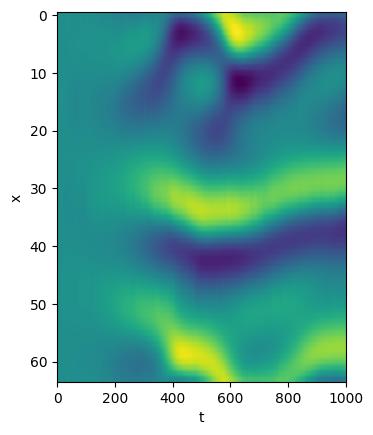

In [26]:
plt.figure()
plt.imshow(state_arr1.T, aspect=20)
plt.xlabel('t')
plt.ylabel('x')

Text(0, 0.5, 'x')

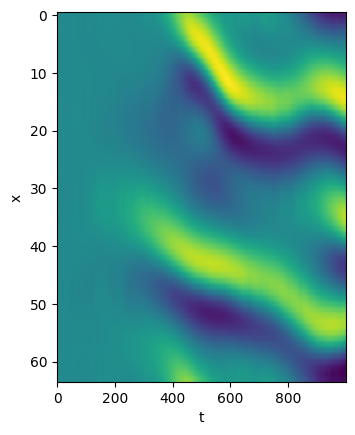

In [27]:
plt.figure()
plt.imshow(state_arr2.T, aspect=20)
plt.xlabel('t')
plt.ylabel('x')

In [1]:
## test replay buffer
import jax
import jax.numpy as jnp
from replay_buffer_jax import init_replay_buffer, add_experience, sample_experiences

# Example usage
rng_key = jax.random.PRNGKey(42)
buffer_capacity = 1000
state_dim = (4,)  # Example state space dimension
action_dim = (2,)  # Example action space dimension

# Initialize the buffer
replay_buffer = init_replay_buffer(buffer_capacity, state_dim, action_dim, rng_key)

# Example experience
state = jnp.array([0.1, 0.2, 0.3, 0.4])
action = jnp.array([1.0, 0.5])
reward = 1.0
next_state = jnp.array([0.2, 0.3, 0.4, 0.5])
done = False

# Add experience to the buffer
replay_buffer = add_experience(replay_buffer, state, action, reward, next_state, done)

# Sample a batch of experiences
batch_size = 32
(batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones), replay_buffer = sample_experiences(replay_buffer, batch_size)

print("Sampled batch:", batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)



Sampled batch: [[0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]
 [0.1 0.2 0.3 0.4]] [[1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]
 [1.  0.5]] [1. 1. 1. 1. 1. 1. 1. 1

In [38]:
env_N = env_jax.N
model_N = env_jax.N
model_k = env_jax.ks_solver.k
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
u0, obs0, _ = reset_fun(key=key)
std_init = 0.1
m = 10

# fourier transform the initial condition
u0_f = jnp.fft.rfft(u0, axis=-1)
# get lower order
# make sure the magnitude of fourier modes match
u0_f_low = model_N / env_N * u0_f[: len(model_k)]
# create an ensemble by perturbing the real and imaginary parts
# with the given uncertainty
key, subkey = jax.random.split(key)
Af_0_real = jax.random.multivariate_normal(key,
    u0_f_low.real, jnp.diag((u0_f_low.real * std_init) ** 2), (m,), method='svd'
).T
Af_0_complex = jax.random.multivariate_normal(subkey,
    u0_f_low.imag, jnp.diag((u0_f_low.imag * std_init) ** 2), (m,), method='svd'
).T
Af_0 = Af_0_real + Af_0_complex * 1j


In [52]:
jnp.fft.rfft(u0, axis=-1)

Array([-2.08166817e-17+0.j        , -9.50762748e-02+0.10669725j,
       -6.18503094e-02+0.10089489j,  1.15434310e-01+0.04435644j,
       -3.90169735e-02-0.07807626j,  5.31497549e-02-0.0385664j ,
       -1.69421169e-02+0.0953228j ,  2.99043645e-02-0.0177184j ,
        2.77337023e-02-0.01800419j,  5.94673909e-02-0.0506689j ,
        1.73935742e-02-0.05706085j, -4.15944313e-02-0.0820312j ,
       -5.13627600e-02-0.06449333j,  3.67610510e-02+0.00340228j,
        1.55781641e-03-0.12736972j, -1.24693231e-03-0.04156192j,
        3.40487603e-02-0.07664026j, -4.35125786e-03-0.13368625j,
        2.59007760e-02-0.15231894j, -1.64971649e-01-0.01191047j,
       -6.44087874e-02+0.04793075j,  1.76737213e-02-0.06952717j,
        1.80590631e-02-0.0427762j ,  1.26536503e-02-0.02010188j,
        3.34836524e-02+0.06512987j,  1.19758917e-02-0.00363392j,
        1.80358739e-02+0.02013341j, -8.75917712e-02+0.04682662j,
       -4.30325316e-02-0.0174289j ,  4.14497514e-02-0.06973101j,
        2.48600492e-02+0.

## validate code

In [68]:
from ddpg import DDPG
from envs.KS_environment_jax import KSenv
from envs.KS_solver_jax import KS
import jax
import jax.numpy as jnp
from pathlib import Path
import yaml
from functools import partial
from replay_buffer_jax import init_replay_buffer, add_experience, sample_experiences

def load_config(experiment_path):
    with open(experiment_path / "config.yml", "r") as file:
        config = yaml.unsafe_load(file)
        return config

# load config from experiment
experiment_path = Path('local_results/KS/run_20240909_140045') 
config = load_config(experiment_path)

# create environment
env = KSenv(**config.env)
# create agent
agent = DDPG(config, env)

# create low order model
model = KS(
    nu=config.env.nu,
    N=config.enKF.low_order_N,
    dt=env.dt,
    actuator_locs=config.env.actuator_locs,
    actuator_scale=config.env.actuator_scale,
)

In [80]:
config.enKF.wait_steps = 20

In [81]:
def initialize_ensemble(env_N, model_N, model_k, u0, std_init, m, key):
    # fourier transform the initial condition
    u0_f = jnp.fft.rfft(u0, axis=-1)
    # get lower order
    # make sure the magnitude of fourier modes match
    u0_f_low = model_N / env_N * u0_f[: len(model_k)]
    # create an ensemble by perturbing the real and imaginary parts
    # with the given uncertainty
    key, subkey = jax.random.split(key)
    Af_0_real = jax.random.multivariate_normal(key,
        u0_f_low.real, jnp.diag((u0_f_low.real * std_init) ** 2), (m,), method='svd'
    ).T
    # covariance matrix is rank deficient because zeroth
    Af_0_complex = jax.random.multivariate_normal(subkey,
        u0_f_low.imag, jnp.diag((u0_f_low.imag * std_init) ** 2), (m,), method='svd'
    ).T
    Af_0 = Af_0_real + Af_0_complex * 1j
    return Af_0


def get_observation_matrix(model_N, model_L, x):
    # get the matrix to do inverse fft on observation points
    k = model_N * jnp.fft.fftfreq(model_N) * 2 * jnp.pi / model_L
    k_x = jnp.einsum("i,j->ij", x, k) * 1j
    exp_k_x = jnp.exp(k_x)
    M = 1 / model_N * exp_k_x
    return M

def ensemble_to_state(state_ens):
    state = jnp.mean(state_ens, axis=-1)
    # inverse rfft before passing to the neural network
    state = jnp.fft.irfft(state)
    return state

def forecast(state_ens, action, frame_skip, B, lin, ik, dt):
    """
    Forecast the state ensemble over a number of steps.

    Args:
        state_ens: Ensemble of states. Shape [n_ensemble, n_state].
        action: Action applied to the system.
        frame_skip: Number of steps to advance.
        B, lin, ik, dt: KS model parameters.

    Returns:
        Updated state ensemble.
    """
    def step_fn(state, _):
        return jax.vmap(KS.advance_f, in_axes=(-1, None, None, None, None, None), out_axes=-1)(
            state, action, B, lin, ik, dt
        ), None

    # Use lax.scan to iterate over frame_skip and advance the state
    state_ens, _ = jax.lax.scan(step_fn, state_ens, jnp.arange(frame_skip))

    return state_ens

def EnKF(m, Af, d, Cdd, M, key):
    """Taken from real-time-bias-aware-DA by Novoa.
    Ensemble Kalman Filter as derived in Evensen (2009) eq. 9.27.
    Inputs:
        Af: forecast ensemble at time t
        d: observation at time t
        Cdd: observation error covariance matrix
        M: matrix mapping from state to observation space
    Returns:
        Aa: analysis ensemble
    """
    psi_f_m = jnp.mean(Af, 1, keepdims=True)
    Psi_f = Af - psi_f_m

    # Create an ensemble of observations
    D = jax.random.multivariate_normal(key, d, Cdd, (m,), method='svd').T
    # Mapped forecast matrix M(Af) and mapped deviations M(Af')
    Y = jnp.real(jnp.dot(M, Af))
    S = jnp.real(jnp.dot(M, Psi_f))
    # because we are multiplying with M first, we get real values
    # so we never actually compute the covariance of the complex-valued state
    # if i have to do that, then make sure to do it properly with the complex conjugate!!
    # Matrix to invert
    C = (m - 1) * Cdd + jnp.dot(S, S.T)
    # Cinv = jnp.linalg.inv(C)

    # X = jnp.dot(S.T, jnp.dot(Cinv, (D - Y)))
    X = jnp.dot(S.T, jnp.linalg.solve(C, D-Y)) 

    Aa = Af + jnp.dot(Af, X)
    return Aa


def apply_enKF(m, k, Af, d, Cdd, M, key):
    Af_full = jnp.vstack((Af, jnp.conjugate(jnp.flip(Af[1:-1, :], axis=0))))
    Aa_full = EnKF(m, Af_full, d, Cdd, M, key)
    Aa = Aa_full[: k, :]
    return Aa

# get the observation matrix that maps state to observations
obs_mat = get_observation_matrix(model.N, model.L, env.observation_locs)

# standard deviation of the exploration scales with the range of actions in the environment
exploration_stddev = (
    env.action_high - env.action_low
) * config.train.exploration_stddev

# create a action of zeros to pass
null_action = jnp.zeros(env.action_size)

# jit the necessary environment functions
initialize_ensemble = partial(initialize_ensemble, 
                                  env_N=env.N,
                                  model_N=model.N, 
                                  model_k=model.k, 
                                  std_init=config.enKF.std_init, 
                                  m=config.enKF.m)
initialize_ensemble = jax.jit(initialize_ensemble)

env_reset = partial(KSenv.reset,
                    N=env.N,
                    B=env.ks_solver.B, 
                    lin=env.ks_solver.lin, 
                    ik=env.ks_solver.ik, 
                    dt=env.ks_solver.dt, 
                    initial_amplitude=env.initial_amplitude, 
                    action_size=env.action_size, 
                    burn_in=env.burn_in, 
                    observation_inds=env.observation_inds)
env_reset = jax.jit(env_reset)
env_step = partial(KSenv.step,
                    frame_skip=env.frame_skip,
                    B=env.ks_solver.B, 
                    lin=env.ks_solver.lin, 
                    ik=env.ks_solver.ik, 
                    dt=env.ks_solver.dt, 
                    target=env.target,  
                    actuator_loss_weight=env.actuator_loss_weight, 
                    termination_threshold=env.termination_threshold, 
                    observation_inds=env.observation_inds)
env_step = jax.jit(env_step)
env_sample_action = partial(KSenv.sample_continuous_space, 
                            low=env.action_low, 
                            high=env.action_high, 
                            shape=(env.action_size,))
env_sample_action = jax.jit(env_sample_action)

model_forecast = partial(forecast, 
                            frame_skip=env.frame_skip,
                            B=model.B, 
                            lin=model.lin, 
                            ik=model.ik, 
                            dt=model.dt)
model_forecast = jax.jit(model_forecast)

model_apply_enKF = partial(apply_enKF,
                            m = config.enKF.m,
                            k = len(model.k),
                            M = obs_mat,)
model_apply_enKF = jax.jit(model_apply_enKF)

def until_first_observation(true_state, true_obs, state_ens, observation_starts):
    def body_fun(carry, _):
        true_state, true_obs, state_ens = carry
        # advance true environment
        true_state, true_obs, _, _, _, _ = env_step(state=true_state,action=null_action)
        # advance model
        state_ens = model_forecast(state_ens=state_ens, action=null_action)
        return (true_state, true_obs, state_ens), (true_state, true_obs, state_ens)
    (true_state, true_obs, state_ens), (true_state_arr, true_obs_arr, state_ens_arr) = jax.lax.scan(body_fun, (true_state, true_obs, state_ens), jnp.arange(observation_starts))
    return true_state, true_obs, state_ens, true_state_arr, true_obs_arr, state_ens_arr

def act_observe_and_forecast(true_state, true_obs, state_ens, params, wait_steps, episode_steps, key_obs):
        def forecast_fun(carry, _):
            true_state, true_obs, state_ens = carry
            state = ensemble_to_state(state_ens)

            # get action
            action = agent.actor.apply(params, state)

            # get the next observation and reward with this action
            true_state, true_obs, reward, _, _, _ = env_step(state=true_state, action=action)

            # forecast
            state_ens = model_forecast(state_ens=state_ens, action=action)
            return (true_state, true_obs, state_ens), (true_state, true_obs, state_ens, reward)

        def body_fun(carry, _):
            # observe
            # we got an observation
            # define observation covariance matrix
            true_state, true_obs, state_ens, key_obs = carry
            obs_cov = (
                jnp.diag((config.enKF.std_obs * jnp.ones(len(true_obs))))
                * jnp.max(abs(true_obs), axis=0) ** 2
            )

            # add noise on the observation
            key_obs, key_enKF = jax.random.split(key_obs)
            obs = jax.random.multivariate_normal(key_obs, true_obs, obs_cov, method='svd')
        
            # apply enkf to correct the state estimation
            state_ens = model_apply_enKF(Af=state_ens, d=obs, Cdd=obs_cov, key=key_enKF)
            (true_state, true_obs, state_ens), (true_state_arr, true_obs_arr, state_ens_arr, reward_arr) = jax.lax.scan(forecast_fun, (true_state, true_obs, state_ens), jnp.arange(wait_steps))
            return (true_state, true_obs, state_ens, key_obs), (true_state_arr, true_obs_arr, obs, state_ens_arr, reward_arr)
        
        n_loops = episode_steps // wait_steps
        (true_state, true_obs, state_ens, _), (true_state_arr, true_obs_arr, obs_arr, state_ens_arr, reward_arr) = jax.lax.scan(body_fun, (true_state, true_obs, state_ens, key_obs), jnp.arange(n_loops))
        return true_state, true_obs, state_ens, true_state_arr, true_obs_arr, obs_arr, state_ens_arr, reward_arr 

def random_observe_and_forecast(true_state, true_obs, state_ens, wait_steps, episode_steps, key_obs, key_action, replay_buffer):
    def forecast_fun(carry, _):
        true_state, true_obs, state_ens, key_action, replay_buffer = carry
        state = ensemble_to_state(state_ens)

        # get action
        key_action, _ = jax.random.split(key_action)
        action = env_sample_action(key=key_action)

        # get the next observation and reward with this action
        next_true_state, next_true_obs, reward, terminated, _, _ = env_step(state=true_state, action=action)

        # forecast
        next_state_ens = model_forecast(state_ens=state_ens, action=action)
        next_state = ensemble_to_state(next_state_ens)

        replay_buffer = add_experience(replay_buffer, state, action, reward, next_state, terminated)
        return (next_true_state, next_true_obs, next_state_ens, key_action, replay_buffer), (true_state, true_obs, state_ens, reward)

    def body_fun(carry, _):
        # observe
        # we got an observation
        # define observation covariance matrix
        true_state, true_obs, state_ens, key_obs, key_action, replay_buffer = carry
        obs_cov = (
            jnp.diag((config.enKF.std_obs * jnp.ones(len(true_obs))))
            * jnp.max(abs(true_obs), axis=0) ** 2
        )

        # add noise on the observation
        key_obs, key_enKF = jax.random.split(key_obs)
        obs = jax.random.multivariate_normal(key_obs, true_obs, obs_cov, method='svd')
    
        # apply enkf to correct the state estimation
        state_ens = model_apply_enKF(Af=state_ens, d=obs, Cdd=obs_cov, key=key_enKF)
        (true_state, true_obs, state_ens, key_action, replay_buffer), (true_state_arr, true_obs_arr, state_ens_arr, reward_arr) = jax.lax.scan(forecast_fun, (true_state, true_obs, state_ens, key_action, replay_buffer), jnp.arange(wait_steps))
        return (true_state, true_obs, state_ens, key_obs, key_action, replay_buffer), (true_state_arr, true_obs_arr, obs, state_ens_arr, reward_arr)
    
    n_loops = episode_steps // wait_steps
    (true_state, true_obs, state_ens, _, _, replay_buffer), (true_state_arr, true_obs_arr, obs_arr, state_ens_arr, reward_arr) = jax.lax.scan(body_fun, (true_state, true_obs, state_ens, key_obs, key_action, replay_buffer), jnp.arange(n_loops))
    return true_state, true_obs, state_ens, true_state_arr, true_obs_arr, obs_arr, state_ens_arr, reward_arr, replay_buffer

until_first_observation = partial(until_first_observation, observation_starts = config.enKF.observation_starts)
until_first_observation = jax.jit(until_first_observation)

act_observe_and_forecast = partial(act_observe_and_forecast, wait_steps = config.enKF.wait_steps, episode_steps=config.episode_steps-config.enKF.observation_starts)
# act_observe_and_forecast = jax.jit(act_observe_and_forecast)

random_observe_and_forecast = partial(random_observe_and_forecast, wait_steps = config.enKF.wait_steps, episode_steps=config.episode_steps-config.enKF.observation_starts)
random_observe_and_forecast = jax.jit(random_observe_and_forecast)

def act_evaluate_episode(key_env, key_obs, params):
    # reset the environment
    key_env, key_ens = jax.random.split(key_env)
    init_true_state, init_true_obs, _ = env_reset(key=key_env)

    # initialize enKF
    init_state_ens = initialize_ensemble(u0=init_true_state,key=key_ens)

    # forecast until first observation
    true_state, true_obs, state_ens, true_state_arr0, true_obs_arr0, state_ens_arr0 = until_first_observation(true_state=init_true_state, true_obs=init_true_obs, state_ens=init_state_ens)
    true_state, true_obs, state_ens, true_state_arr, true_obs_arr, obs_arr, state_ens_arr, reward_arr = act_observe_and_forecast(true_state=true_state, true_obs=true_obs, state_ens=state_ens, params=params, key_obs=key_obs)
    
    true_state_arr = jnp.reshape(true_state_arr, (true_state_arr.shape[0]*true_state_arr.shape[1], true_state_arr.shape[2]))
    state_ens_arr = jnp.reshape(state_ens_arr, (state_ens_arr.shape[0]*state_ens_arr.shape[1], state_ens_arr.shape[2], state_ens_arr.shape[3]))
    true_obs_arr = jnp.reshape(true_obs_arr, (true_obs_arr.shape[0]*true_obs_arr.shape[1], true_obs_arr.shape[2]))
    
    stack = lambda a,b,c: jnp.vstack((jnp.expand_dims(a,axis=0),b,c))

    return (stack(init_true_state, true_state_arr0, true_state_arr), 
            stack(init_true_obs, true_obs_arr0, true_obs_arr), 
            obs_arr,
            stack(init_state_ens, state_ens_arr0, state_ens_arr),
            reward_arr
            )

def random_evaluate_episode(key_env, key_obs, key_action, replay_buffer):
        # do i need to pass actor state?
        # reset the environment
        key_env, key_ens = jax.random.split(key_env)
        init_true_state, init_true_obs, _ = env_reset(key=key_env)

        # initialize enKF
        init_state_ens = initialize_ensemble(u0=init_true_state,key=key_ens)

        # forecast until first observation
        true_state, true_obs, state_ens, true_state_arr0, true_obs_arr0, state_ens_arr0 = until_first_observation(true_state=init_true_state, true_obs=init_true_obs, state_ens=init_state_ens)
        true_state, true_obs, state_ens, true_state_arr, true_obs_arr, obs_arr, state_ens_arr, reward_arr, replay_buffer = random_observe_and_forecast(true_state=true_state, true_obs=true_obs, state_ens=state_ens, key_obs=key_obs, key_action=key_action, replay_buffer=replay_buffer)
        
        true_state_arr = jnp.reshape(true_state_arr, (true_state_arr.shape[0]*true_state_arr.shape[1], true_state_arr.shape[2]))
        state_ens_arr = jnp.reshape(state_ens_arr, (state_ens_arr.shape[0]*state_ens_arr.shape[1], state_ens_arr.shape[2], state_ens_arr.shape[3]))
        true_obs_arr = jnp.reshape(true_obs_arr, (true_obs_arr.shape[0]*true_obs_arr.shape[1], true_obs_arr.shape[2]))
        
        stack = lambda a,b,c: jnp.vstack((jnp.expand_dims(a,axis=0),b,c))

        return (stack(init_true_state, true_state_arr0, true_state_arr), 
                stack(init_true_obs, true_obs_arr0, true_obs_arr), 
                obs_arr,
                stack(init_state_ens, state_ens_arr0, state_ens_arr),
                reward_arr,
                replay_buffer
                )

In [82]:
def add_gaussian_noise(key, x, stddev):
    noise = stddev * jax.random.normal(key, shape=x.shape)
    return x + noise

def learn_observe_and_forecast(
    true_state,
    true_obs,
    state_ens,
    wait_steps,
    episode_steps,
    key_obs,
    key_action,
    replay_buffer,
    actor_state,
    critic_state,
):
    def forecast_fun(carry, _):
        (
            true_state,
            true_obs,
            state_ens,
            key_action,
            replay_buffer,
            actor_state,
            critic_state,
        ) = carry

        state = ensemble_to_state(state_ens)

        # get action from the learning actor network
        action = agent.actor.apply(actor_state.params, state)

        # add exploration noise on the action
        # original paper adds Ornstein-Uhlenbeck process noise
        # but in other papers this is deemed unnecessary
        key_action, _ = jax.random.split(key_action)
        action = add_gaussian_noise(key_action, action, stddev=exploration_stddev)
        # clip the action so that it obeys the limits set by the environment
        action = jnp.clip(action, min=env.action_low, max=env.action_high)

        # get the next observation and reward with this action
        next_true_state, next_true_obs, reward, terminated, _, _ = env_step(
            state=true_state, action=action
        )

        # forecast
        next_state_ens = model_forecast(state_ens=state_ens, action=action)
        next_state = ensemble_to_state(next_state_ens)

        replay_buffer = add_experience(
            replay_buffer, state, action, reward, next_state, terminated
        )

        sampled, replay_buffer = sample_experiences(
            replay_buffer, config.train.batch_size
        )
        (
            sampled_state,
            sampled_action,
            sampled_next_state,
            sampled_reward,
            sampled_terminated,
        ) = sampled
        critic_state, q_loss = agent.update_critic(
            actor_state,
            critic_state,
            sampled_state,
            sampled_action,
            sampled_next_state,
            sampled_reward,
            sampled_terminated,
        )
        actor_state, policy_loss = agent.update_actor(
            actor_state, critic_state, sampled_state
        )

        actor_state, critic_state = agent.update_target_networks(
            actor_state, critic_state
        )
        return (
            next_true_state,
            next_true_obs,
            next_state_ens,
            key_action,
            replay_buffer,
            actor_state,
            critic_state,
        ), (true_state, true_obs, state_ens, reward, q_loss, policy_loss)

    def body_fun(carry, _):
        # observe
        # we got an observation
        # define observation covariance matrix
        (
            true_state,
            true_obs,
            state_ens,
            key_obs,
            key_action,
            replay_buffer,
            actor_state,
            critic_state,
        ) = carry
        obs_cov = (
            jnp.diag((config.enKF.std_obs * jnp.ones(len(true_obs))))
            * jnp.max(abs(true_obs), axis=0) ** 2
        )

        # add noise on the observation
        key_obs, key_enKF = jax.random.split(key_obs)
        obs = jax.random.multivariate_normal(
            key_obs, true_obs, obs_cov, method="svd"
        )

        # apply enkf to correct the state estimation
        state_ens = model_apply_enKF(Af=state_ens, d=obs, Cdd=obs_cov, key=key_enKF)
        (
            true_state,
            true_obs,
            state_ens,
            key_action,
            replay_buffer,
            actor_state,
            critic_state,
        ), (
            true_state_arr,
            true_obs_arr,
            state_ens_arr,
            reward_arr,
            q_loss_arr,
            policy_loss_arr,
        ) = jax.lax.scan(
            forecast_fun,
            (
                true_state,
                true_obs,
                state_ens,
                key_action,
                replay_buffer,
                actor_state,
                critic_state,
            ),
            jnp.arange(wait_steps),
        )
        return (
            true_state,
            true_obs,
            state_ens,
            key_obs,
            key_action,
            replay_buffer,
            actor_state,
            critic_state,
        ), (true_state_arr, true_obs_arr, obs, state_ens_arr, reward_arr, q_loss_arr, policy_loss_arr)

    n_loops = episode_steps // wait_steps
    (true_state, true_obs, state_ens, _, _, replay_buffer, actor_state, critic_state), (
        true_state_arr,
        true_obs_arr,
        obs_arr,
        state_ens_arr,
        reward_arr,
        q_loss_arr,
        policy_loss_arr,
    ) = jax.lax.scan(
        body_fun,
        (
            true_state,
            true_obs,
            state_ens,
            key_obs,
            key_action,
            replay_buffer,
            actor_state,
            critic_state,
        ),
        jnp.arange(n_loops),
    )
    return (
        true_state,
        true_obs,
        state_ens,
        true_state_arr,
        true_obs_arr,
        obs_arr,
        state_ens_arr,
        reward_arr,
        q_loss_arr,
        policy_loss_arr,
        replay_buffer,
        actor_state,
        critic_state
    )

learn_observe_and_forecast = partial(
        learn_observe_and_forecast,
        wait_steps=config.enKF.wait_steps,
        episode_steps=config.episode_steps - config.enKF.observation_starts,
    )
learn_observe_and_forecast = jax.jit(learn_observe_and_forecast)

def learn_evaluate_episode(
    key_env, key_obs, key_action, replay_buffer, actor_state, critic_state
):
    # reset the environment
    key_env, key_ens = jax.random.split(key_env)
    init_true_state, init_true_obs, _ = env_reset(key=key_env)

    # initialize enKF
    init_state_ens = initialize_ensemble(u0=init_true_state, key=key_ens)

    # forecast until first observation
    (
        true_state,
        true_obs,
        state_ens,
        true_state_arr0,
        true_obs_arr0,
        state_ens_arr0,
    ) = until_first_observation(
        true_state=init_true_state, true_obs=init_true_obs, state_ens=init_state_ens
    )
    (
        true_state,
        true_obs,
        state_ens,
        true_state_arr,
        true_obs_arr,
        obs_arr,
        state_ens_arr,
        reward_arr,
        q_loss_arr,
        policy_loss_arr,
        replay_buffer,
        actor_state,
        critic_state
    ) = learn_observe_and_forecast(
        true_state=true_state,
        true_obs=true_obs,
        state_ens=state_ens,
        key_obs=key_obs,
        key_action=key_action,
        replay_buffer=replay_buffer,
        actor_state=actor_state,
        critic_state=critic_state,
    )

    true_state_arr = jnp.reshape(
        true_state_arr,
        (
            true_state_arr.shape[0] * true_state_arr.shape[1],
            true_state_arr.shape[2],
        ),
    )
    state_ens_arr = jnp.reshape(
        state_ens_arr,
        (
            state_ens_arr.shape[0] * state_ens_arr.shape[1],
            state_ens_arr.shape[2],
            state_ens_arr.shape[3],
        ),
    )
    true_obs_arr = jnp.reshape(
        true_obs_arr,
        (true_obs_arr.shape[0] * true_obs_arr.shape[1], true_obs_arr.shape[2]),
    )

    stack = lambda a, b, c: jnp.vstack((jnp.expand_dims(a, axis=0), b, c))

    return (
        stack(init_true_state, true_state_arr0, true_state_arr),
        stack(init_true_obs, true_obs_arr0, true_obs_arr),
        obs_arr,
        stack(init_state_ens, state_ens_arr0, state_ens_arr),
        reward_arr,
        q_loss_arr,
        policy_loss_arr,
        replay_buffer,
        actor_state,
        critic_state
    )

In [83]:
# random seed for initialization
key = jax.random.PRNGKey(config.seed)
key, key_network, key_buffer, key_env, key_obs, key_action = jax.random.split(key, 6)

# initialize networks
# sample state and action to get the correct shape
state_0 = jnp.array([jnp.zeros(model.N)])
action_0 = jnp.array([jnp.zeros(env.action_size)])
actor_state, critic_state = agent.initial_network_state(key_network, state_0, action_0)

# # initialize buffer
replay_buffer = init_replay_buffer(capacity = config.replay_buffer.capacity, 
                                    state_dim = (model.N,), 
                                    action_dim = (env.action_size,), 
                                    rng_key = key_buffer)
# random inputs
# true_state_arr, true_obs_arr, obs_arr, state_ens_arr, reward_arr, replay_buffer = random_evaluate_episode(key_env, key_obs, key_action, replay_buffer)

# learn
# true_state_arr, true_obs_arr, obs_arr, state_ens_arr, reward_arr, q_loss_arr, policy_loss_arr, replay_buffer, actor_state, critic_state = learn_evaluate_episode(key_env, key_obs, key_action, replay_buffer, actor_state, critic_state)

# act
true_state_arr, true_obs_arr, obs_arr, state_ens_arr, reward_arr = act_evaluate_episode(key_env, key_obs, params=actor_state.target_params)


In [84]:
import numpy as np
import utils.visualizations as vis

def plot_KS_episode(env, model, true_state_arr, true_obs_arr, obs_arr, state_ens_arr):
    x = env.ks_solver.x
    x_obs = env.observation_locs
    target = env.target

    full_obs_mat = get_observation_matrix(model.N, model.L, x)
    obs_mat = get_observation_matrix(model.N, model.L, x_obs)

    # get full state from low order model
    state_ens_arr_ = np.hstack(
        (state_ens_arr, np.conjugate(np.flip(state_ens_arr[:, 1:-1], axis=1)))
    )
    full_state_ens_arr = np.real(
        np.einsum("kjm,ij->kim", state_ens_arr_, full_obs_mat)
    )
    # get the mean
    full_state_mean_arr = np.mean(full_state_ens_arr, axis=-1)

    # get fourier coefficients
    true_state_arr_f = np.fft.rfft(true_state_arr, axis=1)
    mag_state_arr = 2 / env.N * np.abs(true_state_arr_f)
    mag_state_ens_arr = 2 / model.N * np.abs(state_ens_arr)
    mag_state_mean_arr = np.mean(mag_state_ens_arr, axis=-1)

    # get observations from low order model
    obs_ens_arr = np.real(np.einsum("kjm,ij->kim", state_ens_arr_, obs_mat))
    # get the mean
    obs_mean_arr = np.mean(obs_ens_arr, axis=-1)

    # fill the observations
    fig = vis.plot_episode(
        x,
        x_obs,
        target,
        true_state_arr,
        full_state_ens_arr,
        full_state_mean_arr,
        mag_state_arr,
        mag_state_ens_arr,
        mag_state_mean_arr,
        true_obs_arr,
        obs_arr,
        obs_ens_arr,
        obs_mean_arr,
    )
    return fig

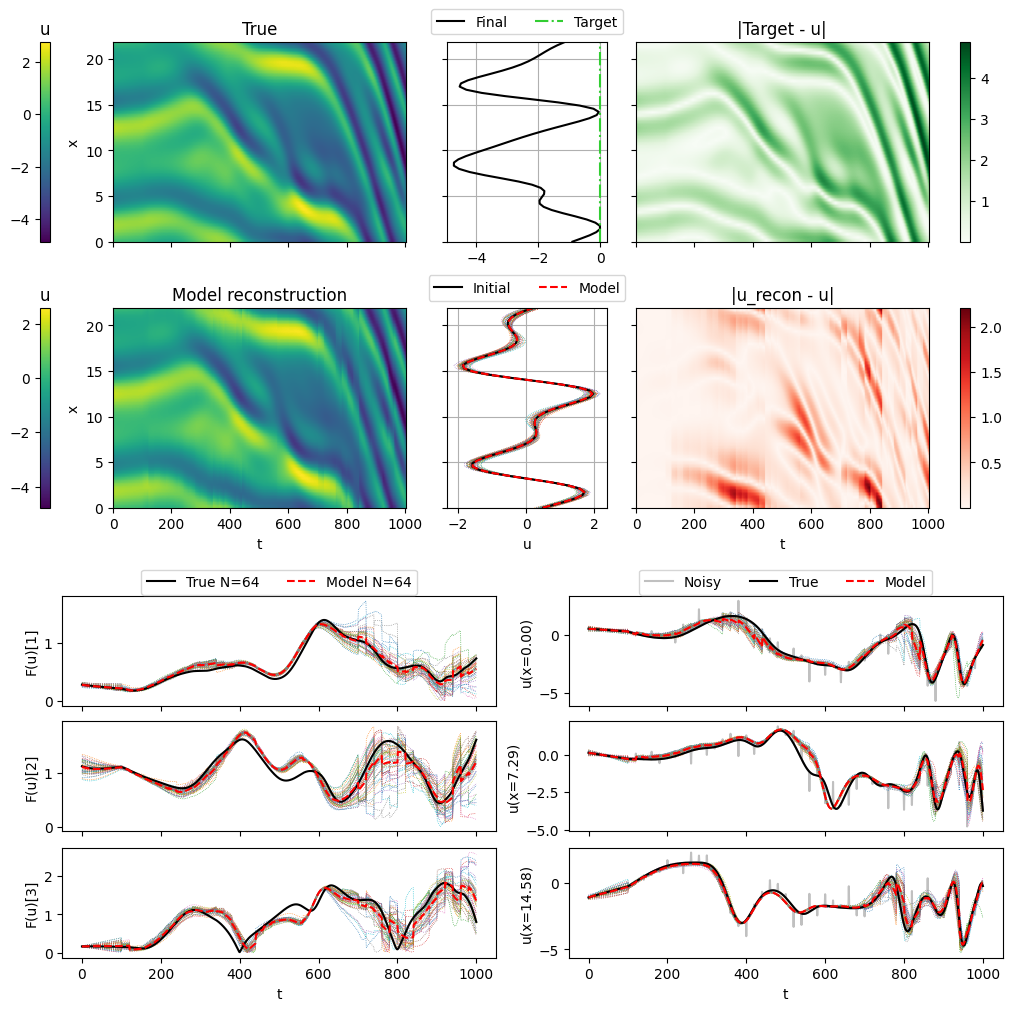

In [85]:
filled_obs_arr = jnp.copy(true_obs_arr)
for i in range(len(obs_arr)):
    filled_obs_arr = filled_obs_arr.at[config.enKF.wait_steps*i+config.enKF.observation_starts].set(obs_arr[i])
fig=plot_KS_episode(env, model, true_state_arr, true_obs_arr, filled_obs_arr, state_ens_arr)

In [6]:
import numpy as np
def forecast(model, state_ens, action, frame_skip):
    for _ in range(frame_skip):
        # advance forecast with low order model
        for m_idx in range(state_ens.shape[-1]):
            state_ens[:, m_idx] = model.advance_f(state_ens[:, m_idx], action)
    return state_ens

def evaluate_episode(init_true_state, init_true_obs, init_state_ens, config, env, actor, params, model, key_obs):
    # reset the environment
    true_obs = np.array(init_true_obs)
    full_state = np.array(init_true_state)
    env.u = full_state

    # initialize enKF
    state_ens = np.array(init_state_ens)

    # Preallocate arrays
    max_steps = config.episode_steps
    # Calculate the total number of steps
    total_steps = max_steps + config.enKF.observation_starts

    # Preallocate arrays using the types of the existing variables
    true_obs_arr = np.empty((total_steps, *true_obs.shape), dtype=true_obs.dtype)
    obs_arr = np.empty((total_steps, *true_obs.shape), dtype=true_obs.dtype)
    full_state_arr = np.empty((total_steps, *full_state.shape), dtype=full_state.dtype)
    state_ens_arr = np.empty((total_steps, *state_ens.shape), dtype=state_ens.dtype)

    # create an action of zeros to pass
    null_action = np.zeros(env.action_space.shape[0])

    # forecast until first observation
    for i in range(config.enKF.observation_starts):
        # Fill in the preallocated arrays
        true_obs_arr[i] = np.array(true_obs)
        obs_arr[i] = np.array(true_obs)
        full_state_arr[i] = np.array(full_state)
        state_ens_arr[i] = np.array(state_ens)

        # advance true environment
        true_obs, _, _, _, _ = env.step(action=null_action)
        full_state = env.u

        # advance model
        state_ens = forecast(
            model, np.array(state_ens), action=null_action, frame_skip=env.frame_skip
        )

    episode_step = 0
    state = ensemble_to_state(state_ens)

    terminated = False
    truncated = False

    while not terminated and not truncated and episode_step < max_steps:
        index = episode_step + config.enKF.observation_starts
        true_obs_arr[index] = np.array(true_obs)
        full_state_arr[index] = np.array(full_state)

        if episode_step % config.enKF.wait_steps == 0:
            obs_cov = (
            jnp.diag((config.enKF.std_obs * jnp.ones(len(true_obs))))
            * jnp.max(abs(true_obs), axis=0) ** 2
            )

            # add noise on the observation
            key_obs, key_enKF = jax.random.split(key_obs)
            obs = jax.random.multivariate_normal(key_obs, true_obs, obs_cov, method='svd')
    
            # apply enkf to correct the state estimation
            state_ens = model_apply_enKF(Af=state_ens, d=obs, Cdd=obs_cov, key=key_enKF)
            state = ensemble_to_state(state_ens)

            obs_arr[index] = np.array(obs)
        else:
            obs_arr[index] = np.array(true_obs)

        # save the analysis state
        state_ens_arr[index] = np.array(state_ens)

        # get action from the target actor network
        action = actor.apply(params, state)
        true_obs, reward, terminated, truncated, _ = env.step(action)
        full_state = env.u

        # forecast
        state_ens = forecast(
            model, np.array(state_ens), action, frame_skip=env.frame_skip
        )
        episode_step += 1

    # Return only the filled parts of the arrays
    return (
        true_obs,
        full_state,
        state_ens,
        true_obs_arr[: index + 1],
        obs_arr[: index + 1],
        full_state_arr[: index + 1],
        state_ens_arr[: index + 1],
        reward,
    )

In [58]:
from envs.KS_environment import KSenv as KSenv2
from envs.KS_solver import KS as KS2
# create environment
env2 = KSenv2(**config.env)
# create low order model
model2 = KS2(
    nu=config.env.nu,
    N=config.enKF.low_order_N,
    dt=env.dt,
    actuator_locs=config.env.actuator_locs,
    actuator_scale=config.env.actuator_scale,
)

(
    true_obs2,
    full_state2,
    state_ens2,
    true_obs_arr2,
    obs_arr2,
    full_state_arr2,
    state_ens_arr2,
    _,
) =  evaluate_episode(init_true_state, init_true_obs, init_state_ens, config, env2, agent.actor, actor_state.params, model2, key_obs)

In [59]:
# get full state from low order model
# get the observation matrix that maps state to observations
full_obs_mat = get_observation_matrix(model.N, model.L, env.ks_solver.x)
state_ens_arr_2 = jnp.hstack(
    (state_ens_arr2, jnp.conjugate(jnp.flip(state_ens_arr2[:, 1:-1], axis=1)))
)
full_state_ens_arr2 = jnp.real(
    jnp.einsum("kjm,ij->kim", state_ens_arr_2, full_obs_mat)
)

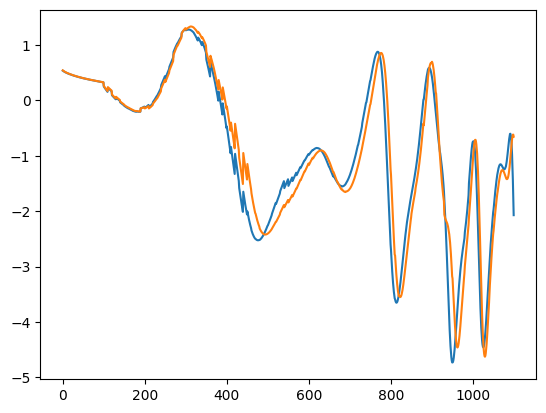

In [60]:
import matplotlib.pyplot as plt
# plt.plot(full_state_arr[:-1,0])
# plt.plot(full_state_arr2[1:,0],'--')
plt.plot(full_state_ens_arr[:,0,0])
plt.plot(full_state_ens_arr2[:,0,0])
plt.show()